In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

# Compromise ($J_{1}=J_{2}=J_{max}$)

Solve equilibrium solutions for case given by the potential:

$U = -J_{12}\cos(\theta_1-\theta_2) - J_{max}\cos(\theta_1-\omega_1) - J_{max}\cos(\theta_2-\omega_2)$

From the equations $\frac{\partial U}{\partial \theta_1}=0$ and $\frac{\partial U}{\partial \theta_2}=0$, summing the two equations we get:

$2\sin(\frac{\theta_1-\omega_1+\theta_2-\omega_2}{2})\cos(\frac{\theta_1-\omega_1-\theta_2+\omega_2}{2})=0$

First we study the case $\theta_1-\omega_1+\theta_2-\omega_2=0$ and then the case $\theta_1-\omega_1-\theta_2+\omega_2=\pi$

## $\theta_1-\omega_1+\theta_2-\omega_2=0$

In [2]:
def dU(theta1, theta2, k, omega1, omega2):
    '''
    Equation of motion
    dU/dtheta1 and dU/dtheta2
    '''
    return np.array([k*np.sin(theta1-theta2) + np.sin(theta1 - omega1), -k*np.sin(theta1-theta2) + np.sin(theta2 - omega2)])

def is_sol(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are solutions of dU=0.
    Return True if they are solutions, False otherwise.
    '''
    delta = abs(dU(theta1, theta2, k, omega1, omega2)) < 1e-3
    return delta[0] and delta[1]

# calculate theta1 and theta2 for different values of K, omega_diff
def calculate_thetas_compromise(K, omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0.
    K = J12/Jmax'''
    omega_diff = omega1 - omega2
    A = np.sin(omega_diff)
    coeff = [4*K**2, -4*K*A, -4*K**2+1, 2*K*A, K**2*A**2]
    roots = np.roots(coeff)
    real_valued = roots.real[abs(roots.imag)<1e-7]
    real_valued = np.unique(real_valued)
    theta1 = np.round(omega1 + np.arcsin(real_valued), 5)
    theta2 = np.round(omega2 - np.arcsin(real_valued), 5)

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    for (t1, t2) in zip(theta1, theta2):
        if not is_sol(t1, t2, K, omega1, omega2):
            theta1[theta1==t1] = np.nan
            theta2[theta2==t2] = np.nan
        if (abs(t1-omega1)>theta0):
            theta1[theta1==t1] = np.nan
        if (abs(t2-omega2)>theta0):
            theta2[theta2==t2] = np.nan
    return theta1, theta2

### Study the parameter space of K and omega_diff

In [3]:
theta0 = np.radians(45)
# # run the calculation and store the results in a csv file

# # initialize thetas

omega2 = 0
theta1 = []
theta2 = []
df = pd.DataFrame(columns=['K', 'omega1', 'omega2', 'theta1', 'theta2'])

# calculate thetas for different values of K, omega_1, omega_2 and store them in a dataframe
for K in np.arange(0.1, 120, 0.2):
    print(K)
    for omega1 in np.arange(0, np.pi, np.pi/180):
        #for omega2 in np.arange(-np.pi/2, np.pi/2, np.pi/40):
        theta1, theta2 = calculate_thetas_compromise(K, omega1, omega2, theta0)
        df = df.append({'K': K, 'omega1': omega1, 'omega2': omega2, 'theta1': theta1, 'theta2': theta2}, ignore_index=True)

# add a column of omega_diff
df['omega_diff'] = df['omega1'] - df['omega2']

# store the dataframe in a csv file
df.to_csv(f'stab_analysis/compromise_{np.degrees(theta0)}theta0_big.csv', index=False)

In [4]:
# read the csv file
#df_comp = pd.read_csv('stab_analysis/compromise_20.0theta0.csv')
df_comp = pd.read_csv('stab_analysis/compromise_20.0theta0_big.csv')

In [5]:
t1 = df_comp['theta1'].values
t2 = df_comp['theta2'].values

for i in range(len(t1)):
    # Convert string to array
    t1[i] = np.fromstring(t1[i][1:-1], sep=' ')
    t2[i] = np.fromstring(t2[i][1:-1], sep=' ')
    
    # Boolean mask of non-NaN elements
    mask = ~np.isnan(t1[i]) & ~np.isnan(t2[i])

    # New arrays with only non-NaN elements
    t1[i] = t1[i][mask]
    t2[i] = t2[i][mask]

  # put nan in empty arrays
    if len(t1[i])==0:
        t1[i] = np.nan
    else:
      t1[i] = t1[i][0]
    if len(t2[i])==0:
      t2[i] = np.nan
    else:
      t2[i] = t2[i][0]

# put t1 and t2 as columns in df 
df_comp['theta1'] = t1
df_comp['theta2'] = t2

df_comp

,K,omega1,omega2,theta1,theta2,omega_diff
0,0.1,0.000000,0,0.0,0.0,0.000000
1,0.1,0.017453,0,0.01527,0.00218,0.017453
2,0.1,0.034907,0,0.032,0.00291,0.034907
3,0.1,0.052360,0,0.048,0.00436,0.052360
4,0.1,0.069813,0,0.064,0.00582,0.069813
...,...,...,...,...,...,...
107995,119.9,3.054326,0,3.09814,-0.04382,3.054326
107996,119.9,3.071779,0,3.10683,-0.03505,3.071779
107997,119.9,3.089233,0,3.11552,-0.02629,3.089233
107998,119.9,3.106686,0,3.12421,-0.01753,3.106686


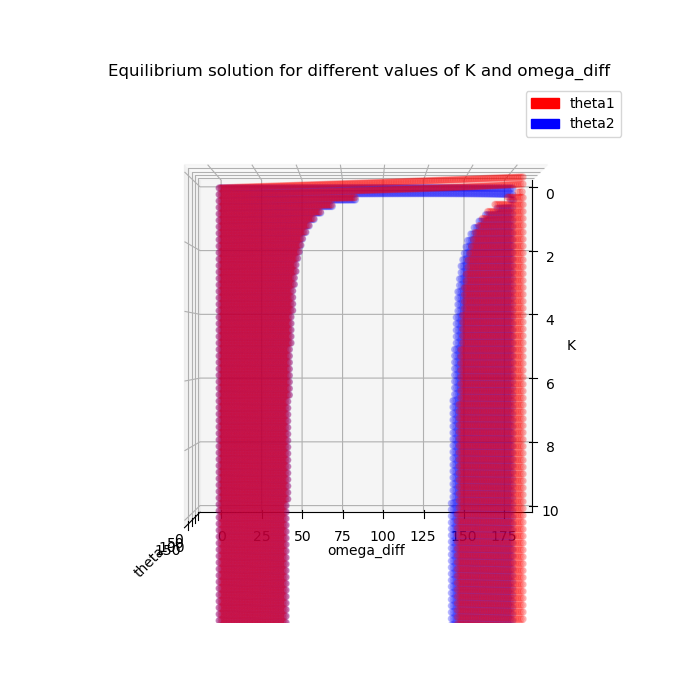

In [6]:
# plot thetas in a 3D plot for different values of K, omega_diff
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('K')
ax.set_ylabel('omega_diff')
ax.set_zlabel('theta')
ax.set_title('Equilibrium solution for different values of K and omega_diff')
ax.scatter(df_comp['K'], np.degrees(df_comp['omega_diff']), df_comp['theta1'].apply(lambda x: np.degrees(x) if not np.isnan(x) else np.nan), c='r', marker='o', alpha=0.2)
ax.scatter(df_comp['K'], np.degrees(df_comp['omega_diff']), df_comp['theta2'].apply(lambda x: np.degrees(x) if not np.isnan(x) else np.nan), c='b', marker='o', alpha=0.2)
red_patch = mpatches.Patch(color='red', label='theta1')
blue_patch = mpatches.Patch(color='blue', label='theta2')
# set K and omega_diff limits
ax.set_xlim(0, 10)
plt.legend(handles=[red_patch, blue_patch])
# show it from the top
ax.view_init(90, 0)

plt.show()


In [29]:
df_comp['theta1'].notna() & df_comp['theta2'].notna()


0         True
1         True
2         True
3         True
4         True
          ... 
107995    True
107996    True
107997    True
107998    True
107999    True
Length: 108000, dtype: bool

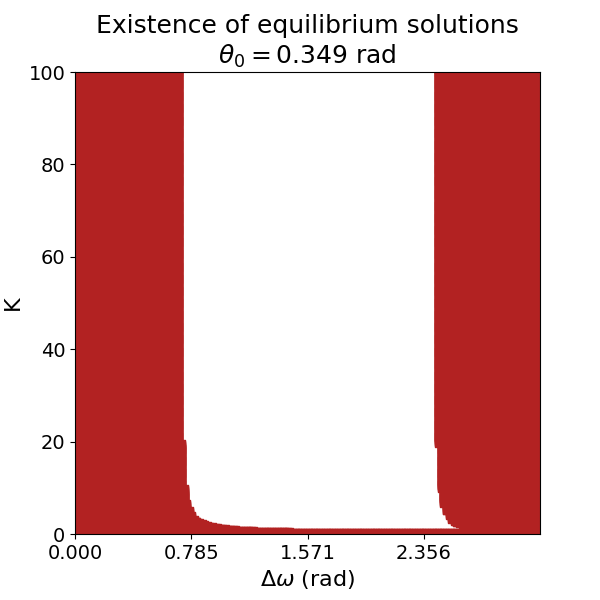

In [30]:
# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
df_both = df_comp[df_comp['theta1'].notna() & df_comp['theta2'].notna()]

# DEGREES
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_title('Existence of equilibrium solutions\n' + r'$\theta_0=$'+f'{np.degrees(theta0)}°', fontsize=18)
# ax.set_ylabel('K', fontsize=16)

# # set x label as delta omega using latex 
# ax.set_xlabel(r'$\Delta \omega$ (°)', fontsize=16)
# ax.set_ylim(0, 100)
# ax.set_xlim(0, 180)
# #ax.set_yticklabels(np.arange(-90, 91, 30))
# #ax.set_xticks(np.arange(0, 11, 2))
# #ax.set_xticklabels(np.arange(0, 11, 2)
# # ax.set_facecolor('white')
# ax.scatter(np.degrees(df_both['omega_diff']), df_both['K'], marker='s', s=35, alpha=1, c='firebrick')
# # increase the tick size and the label size
# ax.tick_params(axis='both', which='major', labelsize=14)
# ax.set_xticks(np.arange(0, 180, 20))

# # save the figure in pdf 300 dpi
# plt.savefig('img/solution_space_compromise_simplify_deg.pdf', dpi=100, bbox_inches='tight')
# plt.show()

# RADIANS
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Existence of equilibrium solutions\n' + r'$\theta_0=$'+f'{round(theta0,3)} rad', fontsize=18)
ax.set_ylabel('K', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, np.pi)
#ax.set_yticklabels(np.arange(-90, 91, 30))
#ax.set_xticks(np.arange(0, 11, 2))
#ax.set_xticklabels(np.arange(0, 11, 2)
# ax.set_facecolor('white')
ax.scatter(df_both['omega_diff'], df_both['K'], marker='s', s=35, alpha=1, c='firebrick')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xticks(np.arange(0, np.pi, np.pi/4))

# save the figure in pdf 300 dpi
#plt.savefig('img/solution_space_compromise_simplify_rad.eps', dpi=100, bbox_inches='tight')
plt.show()


## Stability

In [38]:
def Jacobian(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix 
    '''
    return np.array([[-k*np.cos(theta1-theta2) - np.cos(theta1 - omega1), k*np.cos(theta1-theta2)], [k*np.cos(theta1-theta2), -k*np.cos(theta1-theta2) - np.cos(theta2 - omega2)]])

def is_stable(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    J = Jacobian(theta1, theta2, k, omega1, omega2)
    # check first element of J is positive and the determinant of J is positive
    #return (J[0,0]>0) and (np.linalg.det(J)>0)
    # check if the real part of the eigenvalues is negative
    return np.all(np.real(np.linalg.eigvals(J))<0)

In [37]:
# drop nan values
df_comp = df_comp.dropna()

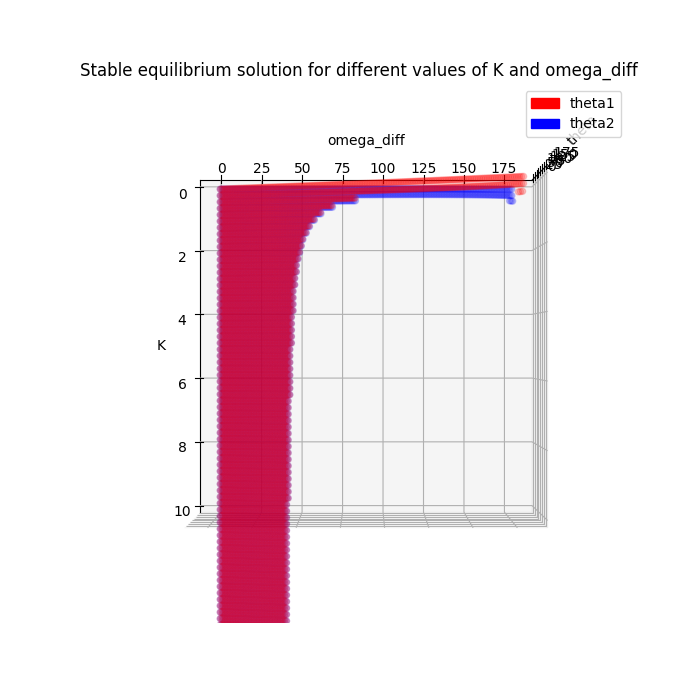

In [39]:

# check if the given elements of theta1 and theta2 in df are stable and store the result in a new column
df_comp['stable'] = df_comp.apply(lambda row: is_stable(row['theta1'], row['theta2'], row['K'], row['omega1'], row['omega2']), axis=1)

# plot the stable thetas in a 3D plot for different values of K, omega_diff
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('K')
ax.set_ylabel('omega_diff')
ax.set_zlabel('theta')
ax.set_title('Stable equilibrium solution for different values of K and omega_diff')
ax.scatter(df_comp[df_comp['stable']==True]['K'], np.degrees(df_comp[df_comp['stable']==True]['omega_diff']), df_comp[df_comp['stable']==True]['theta1'].apply(lambda x: np.degrees(x) if not np.isnan(x) else np.nan), c='r', marker='o', alpha=0.2)
ax.scatter(df_comp[df_comp['stable']==True]['K'], np.degrees(df_comp[df_comp['stable']==True]['omega_diff']), df_comp[df_comp['stable']==True]['theta2'].apply(lambda x: np.degrees(x) if not np.isnan(x) else np.nan), c='b', marker='o', alpha=0.2)
red_patch = mpatches.Patch(color='red', label='theta1')
blue_patch = mpatches.Patch(color='blue', label='theta2')
# set K and omega_diff limits
ax.set_xlim(0, 10)
plt.legend(handles=[red_patch, blue_patch])
# show it from the top
ax.view_init(90, 0)

plt.show()


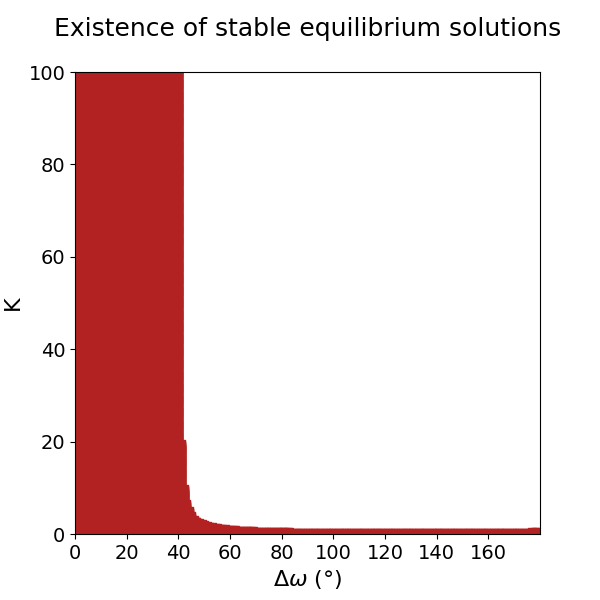

In [40]:
# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
df_both = df_comp[df_comp['theta1'].notna() & df_comp['theta2'].notna() & df_comp['stable']==True]

# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title('Existence of stable equilibrium solutions\n', fontsize=18)
ax.set_ylabel('K', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (°)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, 180)
#ax.set_yticklabels(np.arange(-90, 91, 30))
ax.set_xticks(np.arange(0, 180, 20))
#ax.set_xticklabels(np.arange(0, 11, 2)
# ax.set_facecolor('white')
ax.scatter(np.degrees(df_both['omega_diff']), df_both['K'], marker='s', s=35, alpha=1, c='firebrick')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)

# save the figure in pdf 300 dpi and a specific size in inches
#plt.savefig('img/solution_stable_compromise_simplify_deg.pdf', dpi=100, bbox_inches='tight')
plt.show()

In [12]:
abs_df = df_both[df_both['omega_diff']>0]
# # select max omega_diff for K > 30
# abs_df = abs_df[abs_df['K']>30]
# np.degrees(abs_df['omega_diff'].max())

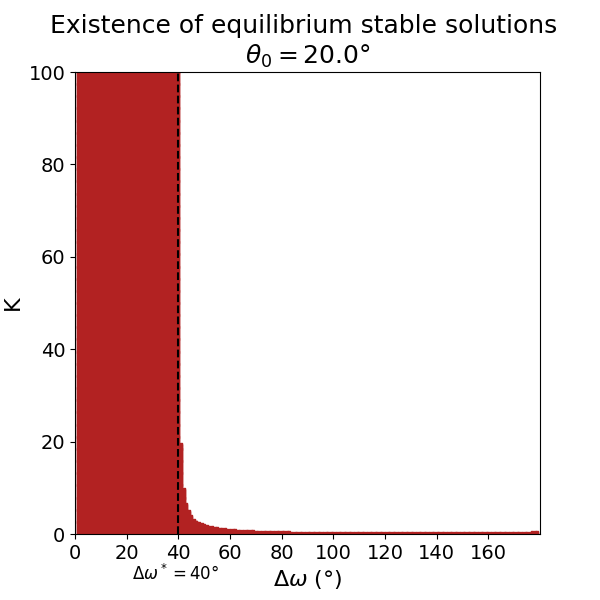

In [13]:
# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
df_both = abs_df[abs_df['theta1'].notna() & abs_df['theta2'].notna() & abs_df['stable']==True]

# RADIANS
# # create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_title(f'Existence of equilibrium stable solutions \n' + r'$\theta_0=$'+f'{round(theta0, 3)} rad', fontsize=18)

# ax.set_ylabel('K', fontsize=16)

# # set x label as delta omega using latex 
# ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
# ax.set_ylim(0, 100)
# ax.set_xlim(0, np.pi)
# ax.scatter(df_both['omega_diff'], df_both['K'], marker='s', s=2, alpha=1, c='firebrick')
# # increase the tick size and the label size
# ax.tick_params(axis='both', which='major', labelsize=14)
# # on x axis set tick every radians
# ax.set_xticks(np.arange(0, np.pi+0.1, np.pi/4))
# # set vertical line at 40 degrees
# ax.axvline(x=np.radians(40), color='black', linestyle='--', alpha=1)
# # set label for vertical line
# om_rad = round(np.radians(40), 3)
# ax.text(np.radians(22), -10, rf'$\Delta \omega^*=${om_rad}', fontsize=12)
# # save the figure in pdf 300 dpi and a specific size in inches
# plt.savefig('img/solution_stable_compromise_simplify_rad.pdf', dpi=100, bbox_inches='tight')
# plt.show()

# # DEGREES
# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f'Existence of equilibrium stable solutions \n' + r'$\theta_0=$'+f'{np.degrees(theta0)}°', fontsize=18)

ax.set_ylabel('K', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (°)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, 180)
ax.scatter(np.degrees(df_both['omega_diff']), df_both['K'], marker='s', s=2, alpha=1, c='firebrick')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)
# on x axis set tick every radians
ax.set_xticks(np.arange(0, 180, 20))
# set vertical line at 40 degrees
ax.axvline(x=40, color='black', linestyle='--', alpha=1)
# set label for vertical line
om_rad = round(40, 3)
ax.text(22, -10, rf'$\Delta \omega^*=${om_rad}°', fontsize=12)
# save the figure in pdf 300 dpi and a specific size in inches
# plt.savefig('img/solution_stable_compromise_simplify_deg.pdf', dpi=100, bbox_inches='tight')
plt.show()

## In this case this other solution doesn't change anything --> $\theta_1-\omega_1-\theta_2+\omega_2=\pi$
## We ignore it

In [14]:
# # calculate theta1 and theta2 for different values of K, omega_diff
# def calculate_thetas2(K, omega1, omega2, theta0):
#     '''
#     Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0.
#     K = J12/Jmax'''
#     omega_diff = omega1 - omega2
#     A = np.sin(omega_diff)
    
#     theta1 = np.round(omega1 + np.arcsin(K*A), 5)
#     theta2 = np.round(omega2 + np.arcsin(K*A) - np.pi, 5)

#     # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
   
#     if not is_sol(theta1, theta2, K, omega1, omega2):
#         theta1 = np.nan
#         theta2 = np.nan
#     if (abs(theta1-omega1)>theta0):
#         theta1 = np.nan
#     if (abs(theta2-omega2)>theta0):
#         theta2 = np.nan
#     return theta1, theta2

In [15]:
# # initialize thetas
# theta0 = np.radians(60)
# theta1 = []
# theta2 = []
# df = pd.DataFrame(columns=['K', 'omega1', 'omega2', 'theta1', 'theta2'])

# # calculate thetas for different values of K, omega_1, omega_2 and store them in a dataframe
# for K in np.arange(0.1, 10.1, 0.1):
#     for omega1 in np.arange(-np.pi/2, np.pi/2, np.pi/30):
#         for omega2 in np.arange(-np.pi/2, np.pi/2, np.pi/30):
#             theta1, theta2 = calculate_thetas2(K, omega1, omega2, theta0)
#             df = df.append({'K': K, 'omega1': omega1, 'omega2': omega2, 'theta1': theta1, 'theta2': theta2}, ignore_index=True)

# df

In [16]:
# # add a column of omega_diff
# df['omega_diff'] = df['omega1'] - df['omega2']

# # plot thetas in a 3D plot for different values of K, omega_diff
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('K')
# ax.set_ylabel('omega_diff')
# ax.set_zlabel('theta')
# ax.set_title('Equilibrium solution for different values of K and omega_diff')
# ax.scatter(df['K'], np.degrees(df['omega_diff']), np.degrees(df['theta1'].apply(lambda x: x[0])), c='r', marker='o', alpha=0.2)
# ax.scatter(df['K'], np.degrees(df['omega_diff']), np.degrees(df['theta2'].apply(lambda x: x[0])), c='b', marker='o', alpha=0.2)
# red_patch = mpatches.Patch(color='red', label='theta1')
# blue_patch = mpatches.Patch(color='blue', label='theta2')
# # set K and omega_diff limits
# ax.set_xlim(0, 10)
# plt.legend(handles=[red_patch, blue_patch])
# # show it from the top
# ax.view_init(90, 0)

# plt.show()

# Decision ($J_{1}=J_{max}, J_{2}=0$)

Solve equilibrium solutions for case given by the potential:

$U = -J_{12}\cos(\theta_1-\theta_2) - J_{max}\cos(\theta_1-\omega_1)$

From the secondo of the equations $\frac{\partial U}{\partial \theta_1}=0$ and $\frac{\partial U}{\partial \theta_2}=0$, we get:

$-J_{12}\sin(\theta_1-\theta_2)=0$ and if we substitute in the first we get:

$J_{12}\sin(\theta_1-\omega_1)=0$

Thus the solution is $\theta_1=\theta_2=\omega_1$ with $\theta_2 \notin [\omega_2-\theta_0, \omega_2+\theta_0]$ 

In [41]:
# calculate theta1 and theta2 for different values of K, omega_diff
def calculate_thetas_decision(omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0.
    '''

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    if abs(omega1-omega2)>theta0:
        return omega1, omega1
    else:
        return np.nan, np.nan

In [42]:
# initialize thetas
# theta0 = np.radians(20)
# omega2 = 0
# theta1 = []
# theta2 = []
# df = pd.DataFrame(columns=['K', 'omega1', 'omega2', 'theta1', 'theta2'])

# # calculate thetas for different values of K, omega_1, omega_2 and store them in a dataframe
# for K in np.arange(0.1, 100.1, 0.2):
#     for omega1 in np.arange(0, np.pi, np.pi/180):
#         #for omega2 in np.arange(-np.pi/2, np.pi/2, np.pi/30):
#         theta1, theta2 = calculate_thetas_decision(omega1, omega2, theta0)
#         df = df.append({'K': K, 'omega1': omega1, 'omega2': omega2, 'theta1': theta1, 'theta2': theta2}, ignore_index=True)

# # add a column of omega_diff
# df['omega_diff'] = df['omega1'] - df['omega2']

# # store the dataframe in a csv file
# df.to_csv(f'stab_analysis/decision_{np.degrees(theta0)}theta0_big.csv', index=False)


# # initialize thetas
# theta0 = np.radians(20)
# omega2 = 0
# theta1 = []
# theta2 = []
# df = pd.DataFrame(columns=['K', 'omega1', 'omega2', 'theta1', 'theta2'])

# # calculate thetas for different values of K, omega_1, omega_2 and store them in a dataframe
# for K in np.arange(0.1, 120, 0.2):
#     for omega1 in np.arange(0, np.pi, np.pi/180):
#         #for omega2 in np.arange(-np.pi/2, np.pi/2, np.pi/40):
#         theta1, theta2 = calculate_thetas_compromise(K, omega1, omega2, theta0)
#         df = df.append({'K': K, 'omega1': omega1, 'omega2': omega2, 'theta1': theta1, 'theta2': theta2}, ignore_index=True)

# # add a column of omega_diff
# df['omega_diff'] = df['omega1'] - df['omega2']

# # store the dataframe in a csv file
# df.to_csv(f'stab_analysis/compromise_{np.degrees(theta0)}theta0_big.csv', index=False)

In [43]:
# read the csv file
df_dec = pd.read_csv('stab_analysis/decision_20.0theta0_big.csv')
df_dec

,K,omega1,omega2,theta1,theta2,omega_diff
0,0.1,0.000000,0.0,NaN,NaN,0.000000
1,0.1,0.017453,0.0,NaN,NaN,0.017453
2,0.1,0.034907,0.0,NaN,NaN,0.034907
3,0.1,0.052360,0.0,NaN,NaN,0.052360
4,0.1,0.069813,0.0,NaN,NaN,0.069813
...,...,...,...,...,...,...
89995,99.9,3.054326,0.0,3.054326,3.054326,3.054326
89996,99.9,3.071779,0.0,3.071779,3.071779,3.071779
89997,99.9,3.089233,0.0,3.089233,3.089233,3.089233
89998,99.9,3.106686,0.0,3.106686,3.106686,3.106686


In [44]:
# put t1 and t2 as columns in df 
# df['theta1'] = t1
# df['theta2'] = t2

# plot thetas in a 3D plot for different values of K, omega_diff
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('K')
# ax.set_ylabel('omega_diff')
# ax.set_zlabel('theta')
# ax.set_title('Equilibrium solution for different values of K and omega_diff')
# ax.scatter(df_dec['K'], np.degrees(df_dec['omega_diff']), np.degrees(df_dec['theta1']), c='r', marker='o', alpha=0.2)
# ax.scatter(df_dec['K'], np.degrees(df_dec['omega_diff']), np.degrees(df_dec['theta2']), c='b', marker='o', alpha=0.2)
# red_patch = mpatches.Patch(color='red', label='theta1')
# blue_patch = mpatches.Patch(color='blue', label='theta2')
# # set K and omega_diff limits
# ax.set_xlim(0, 10)
# plt.legend(handles=[red_patch, blue_patch])
# # show it from the top
# ax.view_init(90, 0)

# plt.show()

## Stability

In [47]:
def Jacobian_decision(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix 
    '''
    return np.array([[-k*np.cos(theta1-theta2) - np.cos(theta1 - omega1), k*np.cos(theta1-theta2)], [k*np.cos(theta1-theta2), -k*np.cos(theta1-theta2)]])

def is_stable(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    J = Jacobian_decision(theta1, theta2, k, omega1, omega2)
    # check first element of J is positive and the determinant of J is positive
    #return (J[0,0]>0) and (np.linalg.det(J)>0)
    return np.all(np.real(np.linalg.eigvals(J))<0)
    
# drop nan values
df_dec = df_dec.dropna()

# check if the given elements of theta1 and theta2 in df are stable and store the result in a new column
df_dec['stable'] = df_dec.apply(lambda row: is_stable(row['theta1'], row['theta2'], row['K'], row['omega1'], row['omega2']), axis=1)



In [19]:
# # plot the stable thetas in a 3D plot for different values of K, omega_diff
# fig = plt.figure(figsize=(7, 7))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel('K')
# ax.set_ylabel('omega_diff')
# ax.set_zlabel('theta')
# ax.set_title('Stable equilibrium solution for different values of K and omega_diff')
# ax.scatter(df_dec[df_dec['stable']==True]['K'], np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), np.degrees(df_dec[df_dec['stable']==True]['theta1']), c='r', marker='o', alpha=0.2)
# ax.scatter(df_dec[df_dec['stable']==True]['K'], np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), np.degrees(df_dec[df_dec['stable']==True]['theta2']), c='b', marker='o', alpha=0.2)
# red_patch = mpatches.Patch(color='red', label='theta1')
# blue_patch = mpatches.Patch(color='blue', label='theta2')
# # set K and omega_diff limits
# ax.set_xlim(0, 10)
# plt.legend(handles=[red_patch, blue_patch])
# # show it from the top
# ax.view_init(0, 0)

# plt.show()

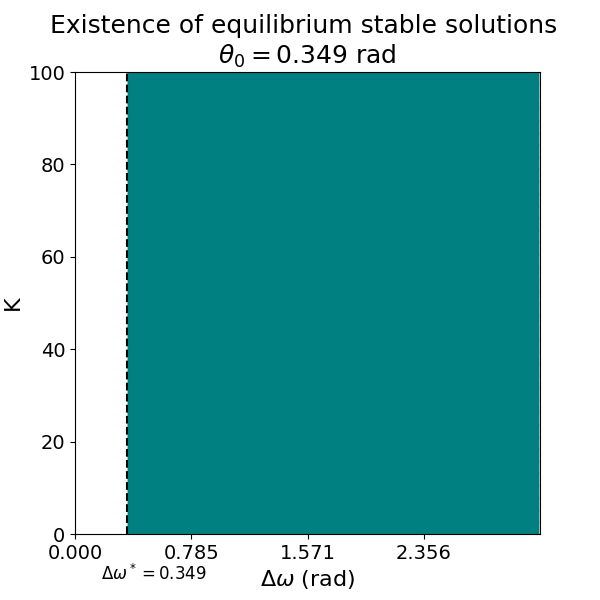

In [48]:
# DEGREES

# # create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
# df_both = df_dec[df_dec['theta1'].notna() & df_dec['theta2'].notna() & df_dec['stable']==True]

# # create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
# fig, ax = plt.subplots(figsize=(6, 6))
# ax.set_title('Existence of stable equilibrium solutions\n', fontsize=18)
# ax.set_ylabel('K', fontsize=16)

# # set x label as delta omega using latex 
# ax.set_xlabel(r'$\Delta \omega$ (°)', fontsize=16)
# ax.set_ylim(0, 100)
# ax.set_xlim(0, 180)
# #ax.set_yticklabels(np.arange(-90, 91, 30))
# ax.set_xticks(np.arange(0, 180, 20))
# #ax.set_xticklabels(np.arange(0, 11, 2)
# # ax.set_facecolor('white')
# ax.scatter(np.degrees(df_both['omega_diff']), df_both['K'], marker='s', s=2, alpha=1, c='teal')
# # increase the tick size and the label size
# ax.tick_params(axis='both', which='major', labelsize=14)

# # set vertical line at theta0
# ax.axvline(x=20, c='black', linestyle='--', alpha=1)

# # save the figure in pdf 300 dpi and a specific size in inches
# plt.savefig('img/solution_stable_decision_simplify_deg.pdf', dpi=100, bbox_inches='tight')
# plt.show()

# RADIANS
# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
df_both = df_dec[df_dec['theta1'].notna() & df_dec['theta2'].notna() & df_dec['stable']==True]

# create a heatmap to visualize when both theta1 and theta2 are solutions. only boolean values are plotted
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title(f'Existence of equilibrium stable solutions \n' + r'$\theta_0=$'+f'{round(theta0, 3)} rad', fontsize=18)
ax.set_ylabel('K', fontsize=16)

# set x label as delta omega using latex 
ax.set_xlabel(r'$\Delta \omega$ (rad)', fontsize=16)
ax.set_ylim(0, 100)
ax.set_xlim(0, np.pi)
#ax.set_yticklabels(np.arange(-90, 91, 30))
ax.set_xticks(np.arange(0, np.pi, np.pi/4))
#ax.set_xticklabels(np.arange(0, 11, 2)
# ax.set_facecolor('white')
ax.scatter(df_both['omega_diff'], df_both['K'], marker='s', s=2, alpha=1, c='teal')
# increase the tick size and the label size
ax.tick_params(axis='both', which='major', labelsize=14)

# set vertical line at theta0
ax.axvline(x=theta0, c='black', linestyle='--', alpha=1)

ax.text(np.radians(10), -10, rf'$\Delta \omega^*=${round(theta0, 3)}', fontsize=12)
# save the figure in pdf 300 dpi and a specific size in inches
# plt.savefig('img/solution_stable_decision_simplify_rad.pdf', dpi=100, bbox_inches='tight')
plt.show()

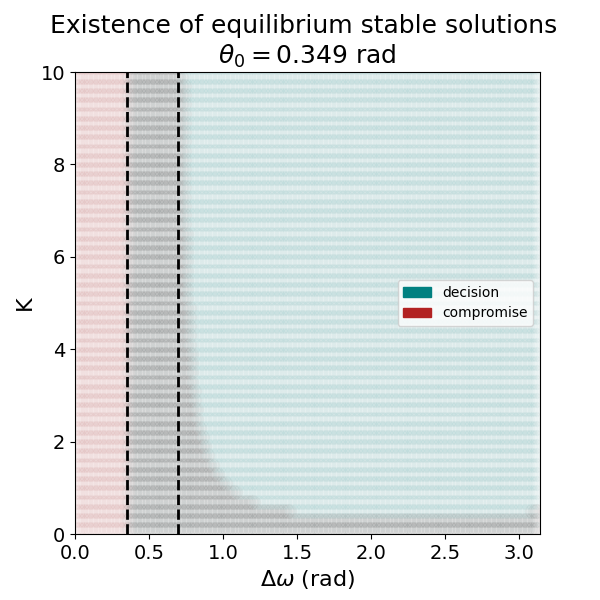

In [49]:
# DEGREES

# # plot phase diagram in 2d for different values of K, omega_diff and boolean plot 
# # with different colors when both df_dec['stable']==True and df_comp['stable']==True
# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111)
# ax.set_xlabel(r'$\Delta\omega$ (°)', fontsize=16)
# ax.set_ylabel('K', fontsize=16)
# ax.set_title('Existence of stable solutions', fontsize=18)
# ax.scatter(np.degrees(df_comp[df_comp['stable']==True]['omega_diff']), df_comp[df_comp['stable']==True]['K'], c='firebrick', alpha=0.02, s=100)
# ax.scatter(np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), df_dec[df_dec['stable']==True]['K'], c='teal', alpha=0.02, s=100)

# # set vertical line at theta0 and 2*theta0
# ax.axvline(x=np.degrees(theta0), c='black', linestyle='--', alpha=1, linewidth=2)
# ax.axvline(x=np.degrees(2*theta0), c='black', linestyle='--', alpha=1, linewidth=2)
# ax.text(8, -5, rf'$\Delta \omega_1=${np.degrees(theta0)}', fontsize=10)
# ax.text(35, -8, rf'$\Delta \omega_2=${np.degrees(2*theta0)}', fontsize=10)



# # set tick size
# ax.tick_params(axis='both', which='major', labelsize=14)
# red_patch = mpatches.Patch(color='firebrick', label='decision')
# blue_patch = mpatches.Patch(color='teal', label='compromise')
# plt.legend(handles=[red_patch, blue_patch])
# #set x limits
# ax.set_xlim(0, 180)
# ax.set_ylim(0, 100)
# #draw vertical lines
# plt.show()

# RADIANS

# plot phase diagram in 2d for different values of K, omega_diff and boolean plot 
# with different colors when both df_dec['stable']==True and df_comp['stable']==True
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Existence of equilibrium stable solutions \n' + r'$\theta_0=$'+f'{round(theta0, 3)} rad', fontsize=18)
ax.set_xlabel(r'$\Delta\omega$ (rad)', fontsize=16)
ax.set_ylabel('K', fontsize=16)
ax.scatter(df_comp[df_comp['stable']==True]['omega_diff'], df_comp[df_comp['stable']==True]['K'], c='firebrick', alpha=0.02, s=100)
ax.scatter(df_dec[df_dec['stable']==True]['omega_diff'], df_dec[df_dec['stable']==True]['K'], c='teal', alpha=0.02, s=100)

# set vertical line at theta0 and 2*theta0
ax.axvline(x=theta0, c='black', linestyle='--', alpha=1, linewidth=2)
ax.axvline(x=2*theta0, c='black', linestyle='--', alpha=1, linewidth=2)
ax.text(np.radians(8), -9, rf'$\Delta \omega_1=${round(theta0, 3)}', fontsize=10)
ax.text(np.radians(35), -12, rf'$\Delta \omega_2=${round(2*theta0, 3)}', fontsize=10)



# set tick size
ax.tick_params(axis='both', which='major', labelsize=14)
red_patch = mpatches.Patch(color='teal', label='decision')
blue_patch = mpatches.Patch(color='firebrick', label='compromise')
plt.legend(handles=[red_patch, blue_patch])
#set x limits
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 10)
#draw vertical lines
plt.show()

# save plot in pdf with 300 dpi
# fig.savefig('img/phase_diagram_rad.pdf', dpi=100)

In [25]:
# for K close to 2/3 check which are the values of theta1 and theta2 that are solutions in df_comp
# df_comp[(df_comp['K']>=0.6) & (df_comp['K']<=0.7) & (df_comp['stable']==True)]

check = df_comp[(round(df_comp['K'],1)==0.5) & (abs((df_comp['omega_diff'] - np.radians(20))) < 0.01)]
np.degrees(check['omega1'])
tt1 = check['theta1'].values[0]
tt2 = check['theta2'].values[0]
print(np.degrees(tt1))
print(np.degrees(tt2))
print(tt1)
print(tt2)

15.009775359042175
4.9904623955894705
0.26197
0.0871


## Investigate region with small K

# 3rd Case ($J_{1}=J_{2}=0$)

Solve equilibrium solutions for case given by the potential:

$U = -J_{12}\cos(\theta_1-\theta_2)$

We get:

$J_{12}\sin(\theta_1-\theta_2)=0$ and:

$-J_{12}\sin(\theta_1-\omega_1)=0$

Thus the solution is $\theta_1=\theta_2$ with $\theta_i \notin [\omega_i-\theta_0, \omega_i+\theta_0]$ 

In [26]:
# calculate theta1 and theta2 for different values of K, omega_diff
def calculate_thetas_decision(omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0.
    '''

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    if abs(omega1-omega2)>theta0:
        return omega1, omega1
    else:
        return np.nan, np.nan

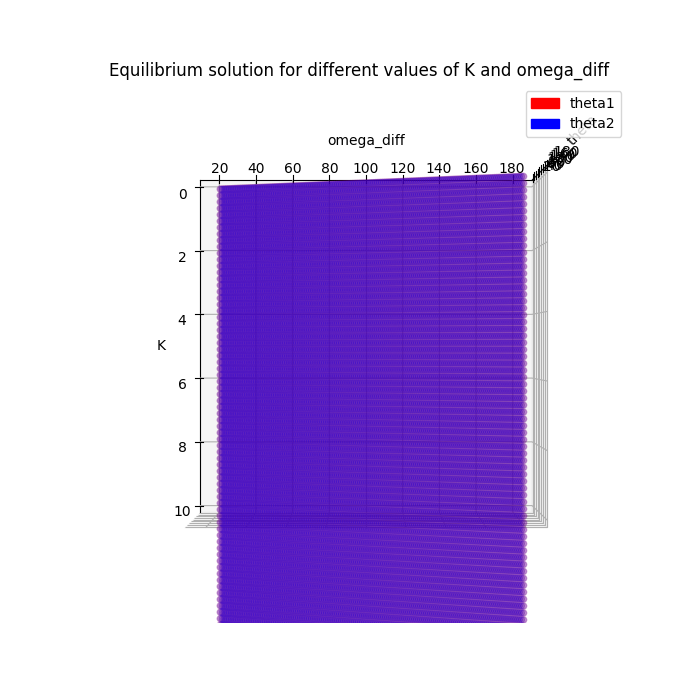

In [27]:
# put t1 and t2 as columns in df 
# df['theta1'] = t1
# df['theta2'] = t2

# plot thetas in a 3D plot for different values of K, omega_diff
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('K')
ax.set_ylabel('omega_diff')
ax.set_zlabel('theta')
ax.set_title('Equilibrium solution for different values of K and omega_diff')
ax.scatter(df_dec['K'], np.degrees(df_dec['omega_diff']), np.degrees(df_dec['theta1']), c='r', marker='o', alpha=0.2)
ax.scatter(df_dec['K'], np.degrees(df_dec['omega_diff']), np.degrees(df_dec['theta2']), c='b', marker='o', alpha=0.2)
red_patch = mpatches.Patch(color='red', label='theta1')
blue_patch = mpatches.Patch(color='blue', label='theta2')
# set K and omega_diff limits
ax.set_xlim(0, 10)
plt.legend(handles=[red_patch, blue_patch])
# show it from the top
ax.view_init(90, 0)

plt.show()

## Stability

In [28]:
def Jacobian_decision(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix 
    '''
    return np.array([[k*np.cos(theta1-theta2) + np.cos(theta1 - omega1), -k*np.cos(theta1-theta2)], [-k*np.cos(theta1-theta2), k*np.cos(theta1-theta2)]])

def is_stable(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    J = Jacobian_decision(theta1, theta2, k, omega1, omega2)
    # check first element of J is positive and the determinant of J is positive
    return (J[0,0]>0) and (np.linalg.det(J)>0)

# check if the given elements of theta1 and theta2 in df are stable and store the result in a new column
df_dec['stable'] = df_dec.apply(lambda row: is_stable(row['theta1'], row['theta2'], row['K'], row['omega1'], row['omega2']), axis=1)

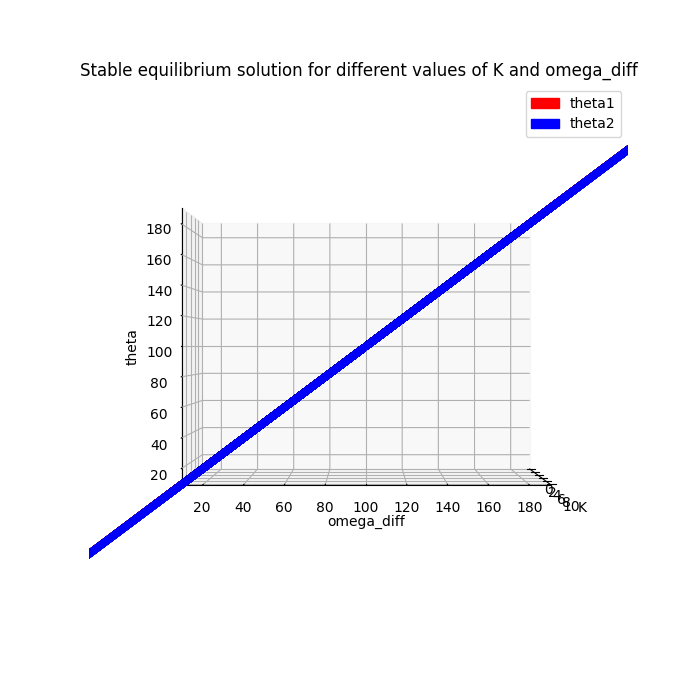

In [29]:
# plot the stable thetas in a 3D plot for different values of K, omega_diff
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('K')
ax.set_ylabel('omega_diff')
ax.set_zlabel('theta')
ax.set_title('Stable equilibrium solution for different values of K and omega_diff')
ax.scatter(df_dec[df_dec['stable']==True]['K'], np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), np.degrees(df_dec[df_dec['stable']==True]['theta1']), c='r', marker='o', alpha=0.2)
ax.scatter(df_dec[df_dec['stable']==True]['K'], np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), np.degrees(df_dec[df_dec['stable']==True]['theta2']), c='b', marker='o', alpha=0.2)
red_patch = mpatches.Patch(color='red', label='theta1')
blue_patch = mpatches.Patch(color='blue', label='theta2')
# set K and omega_diff limits
ax.set_xlim(0, 10)
plt.legend(handles=[red_patch, blue_patch])
# show it from the top
ax.view_init(0, 0)

plt.show()

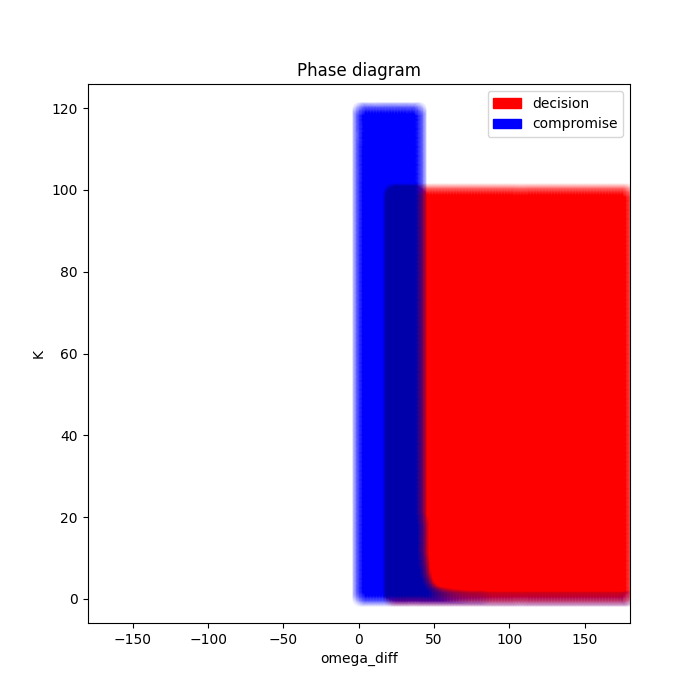

In [30]:
# plot phase diagram in 2d for different values of K, omega_diff and boolean plot 
# with different colors when both df_dec['stable']==True and df_comp['stable']==True
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
ax.set_xlabel('omega_diff')
ax.set_ylabel('K')
ax.set_title('Phase diagram')
ax.scatter(np.degrees(df_dec[df_dec['stable']==True]['omega_diff']), df_dec[df_dec['stable']==True]['K'], c='r', alpha=0.01, s=100)
ax.scatter(np.degrees(df_comp[df_comp['stable']==True]['omega_diff']), df_comp[df_comp['stable']==True]['K'], c='b', alpha=0.01, s=100)

red_patch = mpatches.Patch(color='red', label='decision')
blue_patch = mpatches.Patch(color='blue', label='compromise')
plt.legend(handles=[red_patch, blue_patch])
#set x limits
ax.set_xlim(-180, 180)
plt.show()